# Analysis Twitter data

How can we study a social media as Twitter. The strategy is generally similar.

- data collection (scrapping or API)
- data curation  / management
- exploration of the curated data
- visualisations and advanced analysis

## Step 1 - Collecting data

In this case, I use `twarc` with commandline. Others options exist, for instance as a librairy.

To use `twarc` : https://twarc-project.readthedocs.io/en/latest/twarc2_en_us/

`twarc2 search --archive '#lancetgate OR lancetgate' --end-time "2023-01-01" --start-time "2020-02-01" results_lg.jsonl`

To get the data in a csv format, I use another command line

`twarc2 csv results_lg.jsonl results_lg.csv`

We have a dataset with the tweets. You can download it here : https://www.dropbox.com/s/5lc3cfv8tpriw77/results_lg.zip?dl=0

## Step 2 - exploring the data

Let's use `Pandas`

In [1]:
import pandas as pd

And load the data

In [2]:
data = pd.read_csv("../Data/results_lg.csv", 
                    low_memory=False,
                    dtype={'entities.cashtags':"object"})
data.shape

(135783, 83)

In [3]:
data.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version
0,1609305609211416578,1609305609211416578,NaN,1.608943e+18,NaN,1182419452710838272,NaN,NaN,1.531881e+18,TakeHeight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
1,1609279128456531969,1609279128456531969,NaN,1.609278e+18,NaN,1352449995652296704,NaN,NaN,1.503472e+18,Jikkyleaks,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
2,1609278946524426244,1609278946524426244,NaN,1.602335e+18,NaN,3695081546,NaN,NaN,8.037884e+17,JamesTodaroMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
3,1609278733768364032,1609278733768364032,NaN,1.609278e+18,NaN,73928056,NaN,NaN,1.503472e+18,Jikkyleaks,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
4,1609278314962911238,1608485547202289664,1.609268e+18,NaN,NaN,1503472017412034562,8.293770e+17,DrLizaMD,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0


What are the information we have ?

In [5]:
filtre = pd.isnull(data["retweeted_user_id"]) & pd.isnull(data["quoted_user_id"]) 

In [7]:
filtre.sum()

18285

In [8]:
data[filtre]

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version
4,1609278314962911238,1608485547202289664,1.609268e+18,NaN,NaN,1503472017412034562,8.293770e+17,DrLizaMD,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
5,1609249230551683074,1609180617257648132,1.609245e+18,NaN,NaN,2166832300,3.844850e+07,MolonLabeLegacy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
54,1608992353716678656,1608962848289587203,1.608963e+18,NaN,NaN,4530269002,2.508431e+09,vinceflibustier,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
59,1608988038230855682,1601583411172626432,1.608583e+18,NaN,NaN,1597006245449310213,1.597006e+18,FactAndSerious,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
62,1608942990168567808,1608510374000615424,1.608510e+18,NaN,NaN,1122317376140251139,1.491418e+18,LanChan3322,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135777,1264961240595673088,1264945529949237316,1.264946e+18,NaN,NaN,844492449720520704,1.900028e+09,Enthoven_R,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T22:29:25+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
135778,1264844597244682240,1264844597244682240,NaN,NaN,NaN,844492449720520704,1.191800e+18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T22:29:25+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
135779,1264510784350158848,1264497981090381824,1.264498e+18,NaN,NaN,844492449720520704,9.454734e+08,dr_l_alexandre,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T22:29:25+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
135780,1262799510436081665,1262798535335895040,1.262799e+18,NaN,NaN,1237797265500016640,3.940876e+08,angie_rasmussen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T22:29:25+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0


In [4]:
data.columns

Index(['id', 'conversation_id', 'referenced_tweets.replied_to.id',
       'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id',
       'author_id', 'in_reply_to_user_id', 'in_reply_to_username',
       'retweeted_user_id', 'retweeted_username', 'quoted_user_id',
       'quoted_username', 'created_at', 'text', 'lang', 'source',
       'public_metrics.impression_count', 'public_metrics.reply_count',
       'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.like_count', 'reply_settings', 'edit_history_tweet_ids',
       'edit_controls.edits_remaining', 'edit_controls.editable_until',
       'edit_controls.is_edit_eligible', 'possibly_sensitive',
       'withheld.scope', 'withheld.copyright', 'withheld.country_codes',
       'entities.annotations', 'entities.cashtags', 'entities.hashtags',
       'entities.mentions', 'entities.urls', 'context_annotations',
       'attachments.media', 'attachments.media_keys',
       'attachments.poll.duration_mi

#### Temporal evolution

In [6]:
data["date"] = pd.to_datetime(data['created_at'])
data["num"] = 1

Visualisation

<AxesSubplot:xlabel='date'>

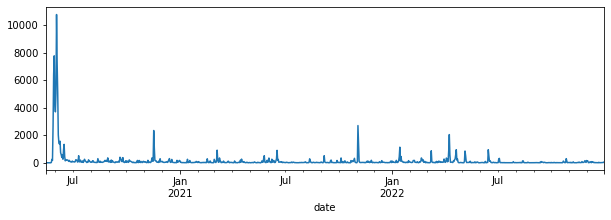

In [17]:
data.set_index("date")["num"].resample("d").sum().plot(figsize=(10,3))

How to investigate around those bursts ?

*Exercice : identify the topic of bursts*

For various reasons, we need to have a better look on tweet. We can build a small tool for visualisation.

In [18]:
import requests
class Tweet(object):
    """
    Object to visualize a specific tweet
    """
    def __init__(self, s):
        """
        s : id of a tweet
        """
        s = f"https://twitter.com/OReillyMedia/status/{s}"
        api = 'https://publish.twitter.com/oembed?url={}'.format(s)
        response = requests.get(api)
        self.text = response.json()["html"]

    def _repr_html_(self):
        return self.text

Testing it on a tweet

In [19]:
Tweet(data.iloc[1000]["id"])

#### Filter original tweets (without retweets)

In [20]:
f_or = pd.isnull(data['referenced_tweets.retweeted.id'])
f_or.sum()

21950

In [22]:
21950/len(data)

0.16165499362954125

#### Identifying the main languages

In [23]:
data['lang'].value_counts().head()

fr     107930
en      20190
qme      1665
es       1627
und      1046
Name: lang, dtype: int64

We can check it is a French thing : https://trends.google.com/trends/explore?q=lancetgate

Let's filter only the french tweets

In [24]:
data = data[data['lang']=="fr"]

In [25]:
len(data)

107930

#### Identifying the main users

In [27]:
data['author.username'].value_counts()

julien0686         421
JaiRaison          393
Despeerad0s        344
FlaurentNeuhaus    331
aragon_jb          290
                  ... 
AnnaeusLucius        1
BoloNono             1
JulienLecaille       1
kuusevana            1
alaqueu              1
Name: author.username, Length: 29181, dtype: int64

Number of users

In [28]:
len(data['author.username'].unique())

29181

<AxesSubplot:>

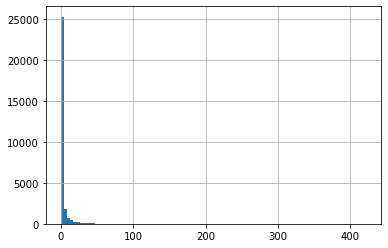

In [29]:
data['author.username'].value_counts().hist(bins=100)

A skew distribution ...

#### What are the most visible tweet

In [31]:
data[["id",'public_metrics.retweet_count']].sort_values('public_metrics.retweet_count',
                                                        ascending=False)

,id,public_metrics.retweet_count
99905,1268212139568828417,3666
102957,1268127762914643969,3666
102902,1268128876573741056,3666
102900,1268128941321134080,3666
102899,1268128946656358400,3666
...,...,...
83776,1268919682662313985,0
121230,1266727103996866568,0
128659,1266453350087884800,0
83782,1268919341598289920,0


In [32]:
Tweet(1268115704311689218)

### Extract hashtags

Add a new column in the dataframe with the list of hashtags for each tweet

(in this case, the metadata are not very friendly)

In [37]:
import re # standard module for regular expression

def extract_hashtags(text):
    """
    function to extract hashtags in a text
    """
    return re.findall("(#\w+)", text.lower())

In [38]:
extract_hashtags("it is a sentence with an #hashtag")

['#hashtag']

In [39]:
data["hashtags"] = data['text'].str.lower().apply(extract_hashtags)

In [40]:
data["hashtags"]

0                                             [#lancetgate]
5                                                        []
6                                             [#lancetgate]
7                                      [#fact, #lancetgate]
8                                                        []
                                ...                        
135775    [#hydroxychloroquine, #lancetgate, #didier_rao...
135776    [#hydroxychloroquine, #lancetgate, #didier_rao...
135777    [#hydroxychloroquine, #lancetgate, #didier_rao...
135778    [#ggrmc, #covidー19, #lancet, #raoult, #lancetg...
135779    [#bigpharma, #chloroquine, #remdesevir, #lance...
Name: hashtags, Length: 107930, dtype: object

## Step 3 : Creating networks

The idea is to create networks to be analyzed in an other software

In [41]:
from itertools import combinations # create combinations of a set

#pip install network
import networkx as nx # library for network analysis in python

### Non directed retweet

I want to create a network with the properties :

- A node is created if a user tweet or retweet. If the user exist, I want to increase by one a parameter weight
- A link is created if a user retweet another one

To create the network

1. Create a graph empty
2. I make a loop on all the tweets
3. For each tweet, in create node/edge

In [43]:
network = nx.Graph()

In [52]:
# create an empty network
network_retweets = nx.Graph()

# A loop for each tweet of my dataset
for i, line in data.iterrows():
    
    # name of the user of the tweet
    user = str(line["author.username"])
    
    # is the user already in my network
    if not user in network_retweets.nodes:
        # if not, we add it with a weight of 1
        network_retweets.add_node(user, label=user, weight=1)
    else:
        # if yes, i only increase its weight
        network_retweets.nodes[user]["weight"] += 1    

    # if the tweet is a retweet
    if pd.notnull(line["retweeted_username"]):

        # the name of the user retweeted
        reweet_user = str(line["retweeted_username"])
        
        # if the retweeted user is not in the network
        if not reweet_user in network_retweets.nodes:
            # create a node
            network_retweets.add_node(reweet_user, label=reweet_user, weight=1)
        else:
            # increase the node
            network_retweets.nodes[reweet_user]["weight"] += 1  

        # if there is a retweet
        if pd.notnull(reweet_user):
            
            # if the edge between retweeted user and retweeting user not exist
            if not network_retweets.has_edge(user, reweet_user):
                # creating the edge
                network_retweets.add_edge(user, reweet_user, weight=1)
            else:
                # increasing its weight
                network_retweets[user][reweet_user]["weight"] += 1 

In [53]:
len(network_retweets.edges)

71560

In [54]:
len(network_retweets.nodes)

29186

Export it as a file we can open on Gephi

In [55]:
nx.write_graphml(network_retweets,"./graph_retweets_lancetgate.graphml")

### hashtags

- 1-mode network
- 2 hashtags connected if mentionned in the same tweet

In [56]:
# empty network
network_hashtags = nx.Graph()

# every tweets
for i, line in data.iterrows():
    
    # adding the nodes
    for e in line["hashtags"]:
        if not e in network_hashtags.nodes:
            network_hashtags.add_node(e, label=e, weight=1)
        else:
            network_hashtags.nodes[e]["weight"] += 1
    
    # adding the edges (all combinations)
    for i, j in combinations(line["hashtags"], 2): 
        if not network_hashtags.has_edge(i, j):
            network_hashtags.add_edge(i, j, weight=1)
        else:
            network_hashtags[i][j]["weight"] += 1

In [57]:
print(len(network_hashtags))

2213


In [58]:
len(network_hashtags.edges)

13786

In [59]:
nx.write_graphml(network_hashtags,"./graph_hashtags_lancetgate.graphml")

## Step 4 : First visualisation

We can try do to dit directly in Python with dedicated tools

In [60]:
from ipysigma import Sigma

In [61]:
Sigma(network_retweets, node_size="weight")

Sigma(nx.Graph with 29,186 nodes and 71,560 edges)

In [62]:
Sigma(network_hashtags, node_size="weight")

Sigma(nx.Graph with 2,213 nodes and 13,786 edges)

Its huge networks, and the visualisation is not the best. We would like to simply them.

- remove the central node
- clustering

Or we can move to a dedicated software : Gephi

In [134]:
nx.write_graphml(network_retweets,"network_retweets.graphml")

## Step 5 : Statistics on the network

In [63]:
network_retweets

In [64]:
degrees = network_retweets.degree

<AxesSubplot:ylabel='Frequency'>

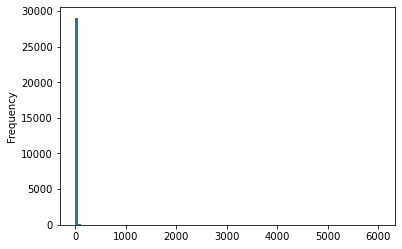

In [65]:
pd.DataFrame(list(degrees))[1].plot(kind="hist",bins=100)

In [66]:
nx.number_connected_components(network_retweets)

2234

Principal component

In [52]:
largest_cc = max(nx.connected_components(network_retweets), key=len)
len(largest_cc)

26743

Extract the component

In [53]:
largest_cc_network = nx.subgraph(network_retweets,largest_cc)

Write it for analysis with gephi

In [54]:
nx.write_graphml(largest_cc_network,"./graph_component_retweets_lancetgate.graphml")

Calculate the density

In [68]:
nx.density(network_retweets)

0.0001680219620388939

Calculate the closeness centrality (could take some time)

In [54]:
nx.closeness_centrality(largest_cc_network,u="raoult_didier")

0.40169809710726173

Find the maximal clique

In [55]:
r = nx.find_cliques(largest_cc_network)

In [58]:
r = [i for i in r]

In [61]:
r[1]

['PatracqSerge', 'andrebercoff']

## Step 6 : Add attributes / transform network

One the exploration is done, we have more specific question, and we will go back to data ...

- Transforming the network : for instance, filter, subsample, etc.
- Adding information : categories, polarities (sentiment analysis)

#### Focus on the core

We will extract only the 3-core of the main component

In [57]:
filtered_largest_cc_network = largest_cc_network.copy()

In [58]:
#remove self-loops
filtered_largest_cc_network.remove_edges_from(nx.selfloop_edges(filtered_largest_cc_network))

r = nx.k_core(filtered_largest_cc_network,k=3)

In [60]:
len(r.nodes),len(filtered_largest_cc_network.nodes)

(7323, 26743)

In [62]:
nx.write_graphml(r,"./graph_3core_component1_retweets_lancetgate.graphml")

#### Clustering

In [136]:
import networkx.algorithms.community as nx_comm 

clusters = nx_comm.louvain_communities(network_hashtags, seed=123, weight="weight")

In [145]:
pd.Series([len(i) for i in clusters]).value_counts()

1       78
2        5
3        4
4        4
10       3
7        3
11       3
12       2
8        2
5        2
51       1
139      1
80       1
1808     1
27       1
9        1
15       1
238      1
223      1
32       1
22       1
6        1
228      1
26       1
127      1
95       1
24       1
47       1
dtype: int64

Adding it to the network ? lets add a new class in each node, and the number of the class but only if there is at least 50 elements in it

## Go further


- directed networks of retweet ?
- links ?
- all words ?
- proximity with the bio of users ?
- can we get an information about the evolution of the network ? How ?
- **build the bimodal network tweets/user to better understand what are the most viral tweets**